# Part 1: Write out the joint probability for the LDA using plate graphic model

<p align="center">
    <center><img src="images/LDA_plate_notation.jpg"></center>
</p>

$$\LARGE P (\beta, \theta, z, w) = \left( \displaystyle\prod_{i=1}^{K} p(\beta_i \ | \ \eta) \right) \ \left( \displaystyle\prod_{d=1}^{D} p(\theta_d \ | \ \alpha) \displaystyle\prod_{n=1}^{N} p(z_{d,n} \ | \ \theta_d) \ p(w_{d,n} \ | \ \beta_{1:K} , z_{d,n}) \right)$$

### Trying to understand the model:

The Big Idea => Each document can be described by a distribution of topics and each topic can be described by a distribution of words.

We don't care about the order of the words (more of a Bag of Words approach) since if you were to scramble the words in an article about sports you would still be able to get a sense of what the topic was about by looking at the individual words.

The LDA model is a form of topic modeling which is a form of unsupervised learning -> model analyzes text data to determin cluster words for a set of documents to discover abstract "topics" that occur in a collection of documents with the goal of mapping all of the documents to topics.

From a collection of documents we want to infer:
 - The per-word topic assignment $\large z_{d,n}$
 - The per-document topic proportions $\large \theta_d$
 - The per-corpus topic distributions $\large \beta_k $
 
Then use prosterior expectations to perform the task

# Part 2: Work out the details in the code from the article "Topic modeling visualization – How to present the results of LDA models?"
https://www.machinelearningplus.com/nlp/topic-modeling-visualization-how-to-present-results-lda-models/

### importing the packages and the 20 News Groups dataset

In [3]:
import sys
# !{sys.executable} -m spacy download en
import re, numpy as np, pandas as pd
from pprint import pprint

# Gensim
import gensim, spacy, logging, warnings
import gensim.corpora as corpora
from gensim.utils import lemmatize, simple_preprocess
from gensim.models import CoherenceModel
import matplotlib.pyplot as plt

# NLTK Stop words
from nltk.corpus import stopwords
stop_words = stopwords.words('english')
stop_words.extend(['from', 'subject', 're', 'edu', 'use', 'not', 'would', 'say', 'could', '_', 'be', 'know', 'good', 'go', 'get', 'do', 'done', 'try', 'many', 'some', 'nice', 'thank', 'think', 'see', 'rather', 'easy', 'easily', 'lot', 'lack', 'make', 'want', 'seem', 'run', 'need', 'even', 'right', 'line', 'even', 'also', 'may', 'take', 'come'])

%matplotlib inline
warnings.filterwarnings("ignore",category=DeprecationWarning)
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.ERROR)

### import the news groups dataset and retain only 4 of the target_names categories.

In [4]:
# Import Dataset
df = pd.read_json('https://raw.githubusercontent.com/selva86/datasets/master/newsgroups.json')

# keep only categories below
df = df.loc[df.target_names.isin(['soc.religion.christian', 'rec.sport.hockey', 'talk.politics.mideast', 'rec.motorcycles']) , :]
print(df.shape)  #> (2361, 3)

# print out the first 5 rows of the df
df.head()

(2361, 3)


,content,target,target_names
10,From: irwin@cmptrc.lonestar.org (Irwin Arnstei...,8,rec.motorcycles
21,From: leunggm@odin.control.utoronto.ca (Gary L...,10,rec.sport.hockey
28,From: jonh@david.wheaton.edu (Jonathan Hayward...,15,soc.religion.christian
33,From: ayr1@cunixa.cc.columbia.edu (Amir Y Rose...,17,talk.politics.mideast
35,From: dchhabra@stpl.ists.ca (Deepak Chhabra)\n...,10,rec.sport.hockey


### Tokenize Sentences and Clean

Text needs to be cleaned and then the words can be tokenized. Emails, punctuation, and symbols are removed and then the document is broken up into separate pieces called tokens made up of individual words.

In [5]:
def sent_to_words(sentences):
    for sent in sentences:
        sent = re.sub('\S*@\S*\s?', '', sent)  # remove emails
        sent = re.sub('\s+', ' ', sent)  # remove newline chars
        sent = re.sub("\'", "", sent)  # remove single quotes
        sent = gensim.utils.simple_preprocess(str(sent), deacc=True) 
        yield(sent)  

# Convert to list
data = df.content.values.tolist()
data_words = list(sent_to_words(data))
print(data_words[:1])

[['from', 'irwin', 'arnstein', 'subject', 're', 'recommendation', 'on', 'duc', 'summary', 'whats', 'it', 'worth', 'distribution', 'usa', 'expires', 'sat', 'may', 'gmt', 'organization', 'computrac', 'inc', 'richardson', 'tx', 'keywords', 'ducati', 'gts', 'how', 'much', 'lines', 'have', 'line', 'on', 'ducati', 'gts', 'model', 'with', 'on', 'the', 'clock', 'runs', 'very', 'well', 'paint', 'is', 'the', 'bronze', 'brown', 'orange', 'faded', 'out', 'leaks', 'bit', 'of', 'oil', 'and', 'pops', 'out', 'of', 'st', 'with', 'hard', 'accel', 'the', 'shop', 'will', 'fix', 'trans', 'and', 'oil', 'leak', 'they', 'sold', 'the', 'bike', 'to', 'the', 'and', 'only', 'owner', 'they', 'want', 'and', 'am', 'thinking', 'more', 'like', 'any', 'opinions', 'out', 'there', 'please', 'email', 'me', 'thanks', 'it', 'would', 'be', 'nice', 'stable', 'mate', 'to', 'the', 'beemer', 'then', 'ill', 'get', 'jap', 'bike', 'and', 'call', 'myself', 'axis', 'motors', 'tuba', 'irwin', 'honk', 'therefore', 'am', 'computrac', 'r

### form the bigram and trigrams using the Phrases model

In [6]:
# Build the bigram and trigram models
bigram = gensim.models.Phrases(data_words, min_count=5, threshold=100) # higher threshold fewer phrases.
trigram = gensim.models.Phrases(bigram[data_words], threshold=100)  
bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)

### lemmatize each word to its root form, keeping only nouns, adjectives, verbs and adverbs.

### We keep only these POS tags because they are the ones contributing the most to the meaning of the sentences

The words that make up the document that are now tokens are lemmatized which means changed to its root form. Th reason for this is simple, since we are taking a more Bag of Words approach the word itself is more important than the context so there isn't any significant difference to organize, organizes, and organizing.

After lemmatizing, most of the information we are interested in comes from the nouns, adjectives, verbs and adverbs, so each token is taged with a part of speech and if not a part of speech listed above its discarded. 

In [7]:
def process_words(texts, stop_words=stop_words, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    """Remove Stopwords, Form Bigrams, Trigrams and Lemmatization"""
    texts = [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]
    texts = [bigram_mod[doc] for doc in texts]
    texts = [trigram_mod[bigram_mod[doc]] for doc in texts]
    texts_out = []
    nlp = spacy.load('en', disable=['parser', 'ner'])
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    # remove stopwords once more after lemmatization
    texts_out = [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts_out]    
    return texts_out

data_ready = process_words(data_words)  # processed Text Data!

## Build the Topic Model

### Build the LDA topic model using LdaModel(), we need the corpus and the dictionary, create them first and then build the model. 

### The trained topics (keywords and weights) are printed below as well.

In [8]:
# Create Dictionary
id2word = corpora.Dictionary(data_ready)

# Create Corpus: Term Document Frequency
corpus = [id2word.doc2bow(text) for text in data_ready]

# Build LDA model
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=4, 
                                           random_state=100,
                                           update_every=1,
                                           chunksize=10,
                                           passes=10,
                                           alpha='symmetric',
                                           iterations=100,
                                           per_word_topics=True)

pprint(lda_model.print_topics())

[(0,
  '0.011*"israeli" + 0.010*"kill" + 0.010*"people" + 0.009*"attack" + '
  '0.008*"government" + 0.008*"state" + 0.008*"war" + 0.007*"turkish" + '
  '0.006*"soldier" + 0.006*"greek"'),
 (1,
  '0.018*"write" + 0.013*"bike" + 0.012*"article" + 0.007*"steal" + '
  '0.007*"rider" + 0.007*"time" + 0.006*"number" + 0.006*"ride" + 0.006*"look" '
  '+ 0.005*"find"'),
 (2,
  '0.034*"team" + 0.026*"game" + 0.018*"year" + 0.017*"play" + 0.015*"player" '
  '+ 0.014*"hockey" + 0.011*"playoff" + 0.011*"wing" + 0.010*"win" + '
  '0.009*"pen"'),
 (3,
  '0.014*"people" + 0.013*"write" + 0.009*"believe" + 0.008*"reason" + '
  '0.006*"article" + 0.006*"evidence" + 0.006*"question" + 0.006*"time" + '
  '0.006*"give" + 0.006*"first"')]


### In LDA models, each document is composed of multiple topics. But, typically only one of the topics is dominant. 

In [9]:
def format_topics_sentences(ldamodel=None, corpus=corpus, texts=data):
    # Init output
    sent_topics_df = pd.DataFrame()

    # Get main topic in each document
    for i, row_list in enumerate(ldamodel[corpus]):
        row = row_list[0] if ldamodel.per_word_topics else row_list            
        # print(row)
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        # Get the Dominant topic, Perc Contribution and Keywords for each document
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:  # => dominant topic
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
            else:
                break
    sent_topics_df.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords']

    # Add original text to the end of the output
    contents = pd.Series(texts)
    sent_topics_df = pd.concat([sent_topics_df, contents], axis=1)
    return(sent_topics_df)


df_topic_sents_keywords = format_topics_sentences(ldamodel=lda_model, corpus=corpus, texts=data_ready)

# Format
df_dominant_topic = df_topic_sents_keywords.reset_index()
df_dominant_topic.columns = ['Document_No', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords', 'Text']
df_dominant_topic.head(10)

,Document_No,Dominant_Topic,Topic_Perc_Contrib,Keywords,Text
0,0,1.0,0.9297,"write, bike, article, steal, rider, time, numb...","[summary, worth, expire, keyword, ducati, gts,..."
1,1,2.0,0.6751,"team, game, year, play, player, hockey, playof...","[group, article, write, course, time, prior, t..."
2,2,3.0,0.8315,"people, write, believe, reason, article, evide...","[write, new, group, maybe, cover, already, cur..."
3,3,0.0,0.5916,"israeli, kill, people, attack, government, sta...","[article, write, article, write, article, writ..."
4,4,1.0,0.4824,"write, bike, article, steal, rider, time, numb...","[goalie_mask, organization, ist, article, writ..."
5,5,1.0,0.6476,"write, bike, article, steal, rider, time, numb...","[bmw_moa_member, read, internet, access, syste..."
6,6,1.0,0.7257,"write, bike, article, steal, rider, time, numb...","[require, organization, article, write, articl..."
7,7,1.0,0.7873,"write, bike, article, steal, rider, time, numb...","[looking, movie, bike, university, latech, sum..."
8,8,3.0,0.9877,"people, write, believe, reason, article, evide...","[organization, university, follow, thread, tal..."
9,9,0.0,0.6230,"israeli, kill, people, attack, government, sta...","[day, night, round, male, inhabitant, article,..."


### The most representative sentence for each topic

In [10]:
# Display setting to show more characters in column
pd.options.display.max_colwidth = 100

sent_topics_sorteddf_mallet = pd.DataFrame()
sent_topics_outdf_grpd = df_topic_sents_keywords.groupby('Dominant_Topic')

for i, grp in sent_topics_outdf_grpd:
    sent_topics_sorteddf_mallet = pd.concat([sent_topics_sorteddf_mallet, 
                                             grp.sort_values(['Perc_Contribution'], ascending=False).head(1)], 
                                            axis=0)

# Reset Index    
sent_topics_sorteddf_mallet.reset_index(drop=True, inplace=True)

# Format
sent_topics_sorteddf_mallet.columns = ['Topic_Num', "Topic_Perc_Contrib", "Keywords", "Representative Text"]

# Show
sent_topics_sorteddf_mallet.head(10)

,Topic_Num,Topic_Perc_Contrib,Keywords,Representative Text
0,0.0,0.9632,"israeli, kill, people, attack, government, state, war, turkish, soldier, greek","[armenian, genocide, people, article, write, ranada, ermeniler, boyle, icin, bulunan, oldurmuler..."
1,1.0,0.9810,"write, bike, article, steal, rider, time, number, ride, look, find","[distribution, organization, originator, seq, message, write, unauthenticated, user, user, neces..."
2,2.0,0.9923,"team, game, year, play, player, hockey, playoff, wing, win, pen","[result, game, play, organization, keyword, boxscore, nhl, result, game, play, standing, adam, c..."
3,3.0,0.9958,"people, write, believe, reason, article, evidence, question, time, give, first","[arrogance, article, write, write, article, write, truth, absolute, scripture, truth, therefore,..."


### Frequency Distribution of Word Counts in Documents

When working with a large number of documents, you want to know how big the documents are as a whole and by topic.

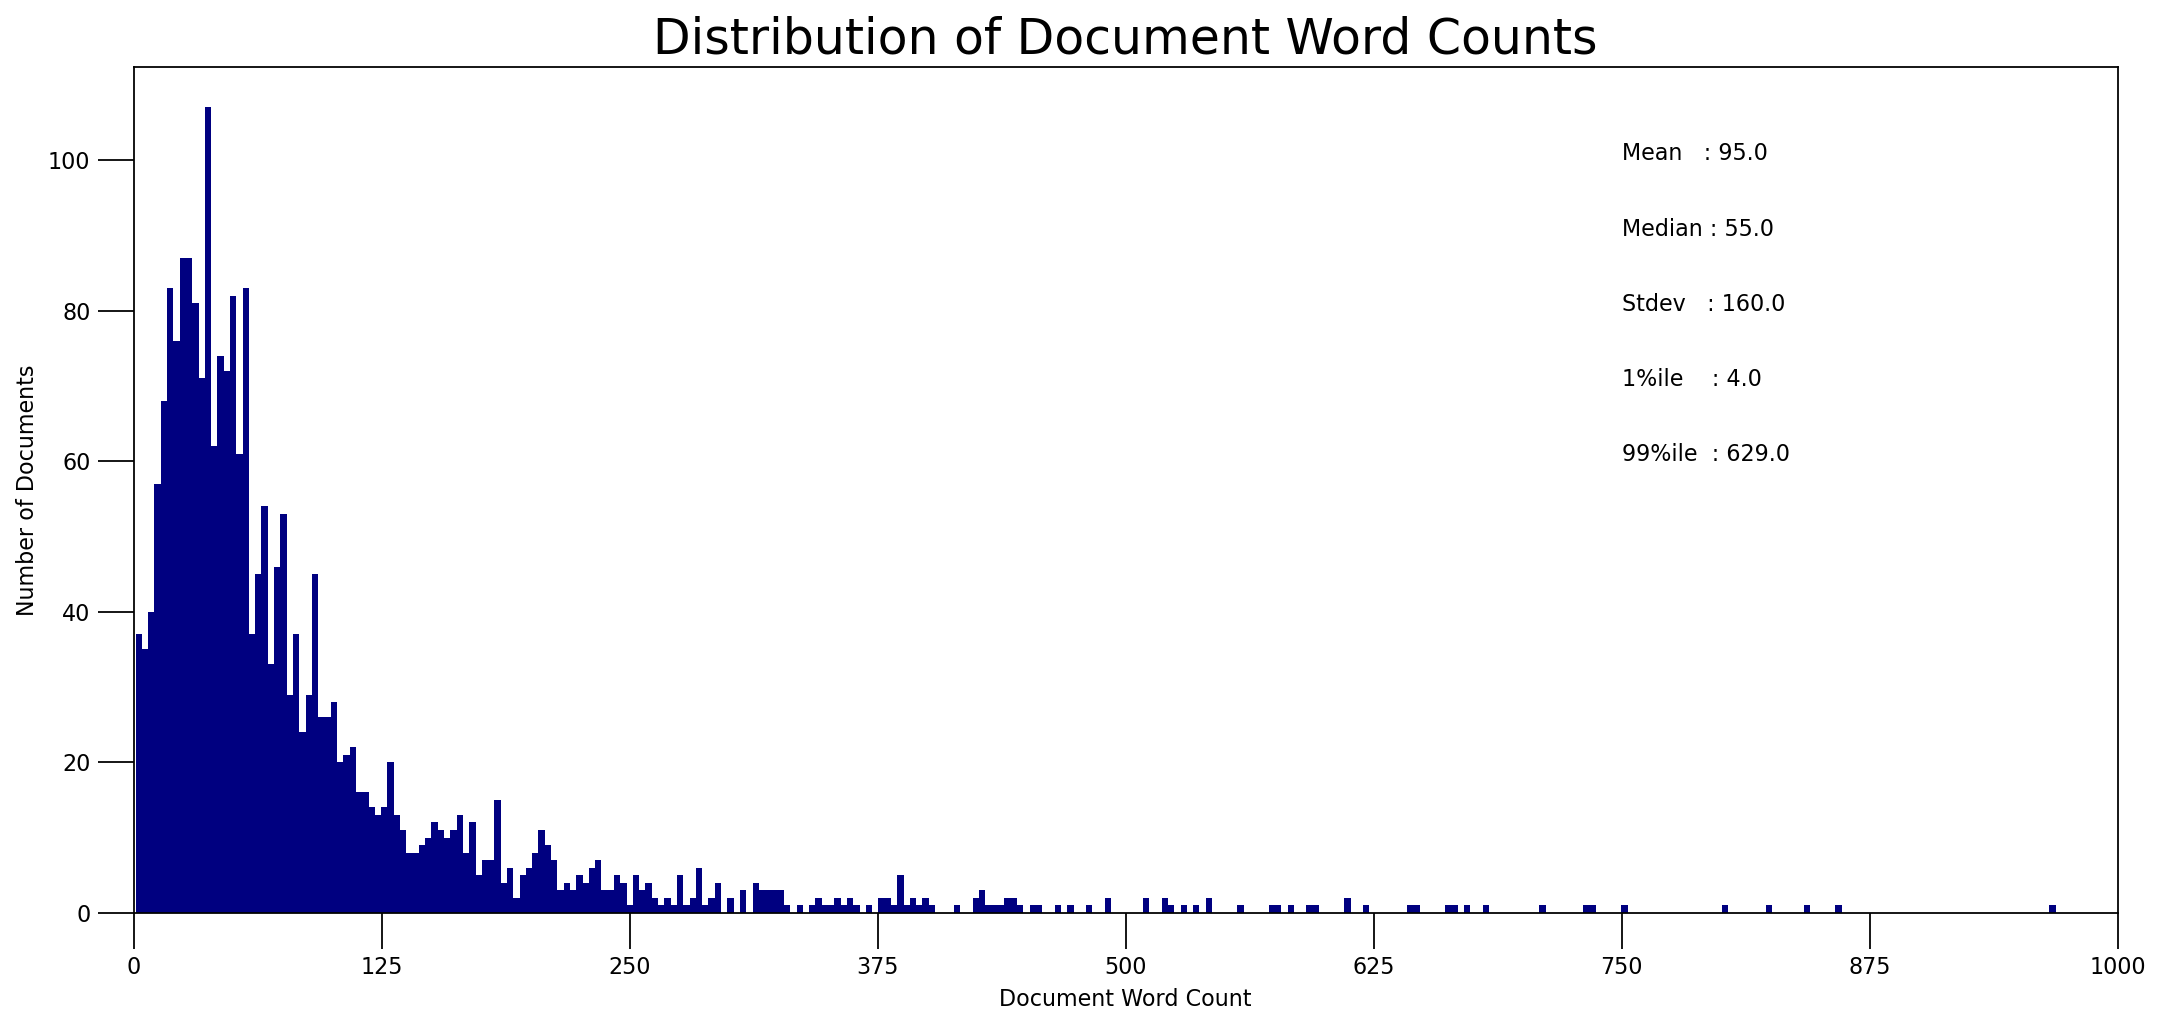

In [11]:
doc_lens = [len(d) for d in df_dominant_topic.Text]

# Plot
plt.figure(figsize=(16,7), dpi=160)
plt.hist(doc_lens, bins = 1000, color='navy')
plt.text(750, 100, "Mean   : " + str(round(np.mean(doc_lens))))
plt.text(750,  90, "Median : " + str(round(np.median(doc_lens))))
plt.text(750,  80, "Stdev   : " + str(round(np.std(doc_lens))))
plt.text(750,  70, "1%ile    : " + str(round(np.quantile(doc_lens, q=0.01))))
plt.text(750,  60, "99%ile  : " + str(round(np.quantile(doc_lens, q=0.99))))

plt.gca().set(xlim=(0, 1000), ylabel='Number of Documents', xlabel='Document Word Count')
plt.tick_params(size=16)
plt.xticks(np.linspace(0,1000,9))
plt.title('Distribution of Document Word Counts', fontdict=dict(size=22))
plt.show()

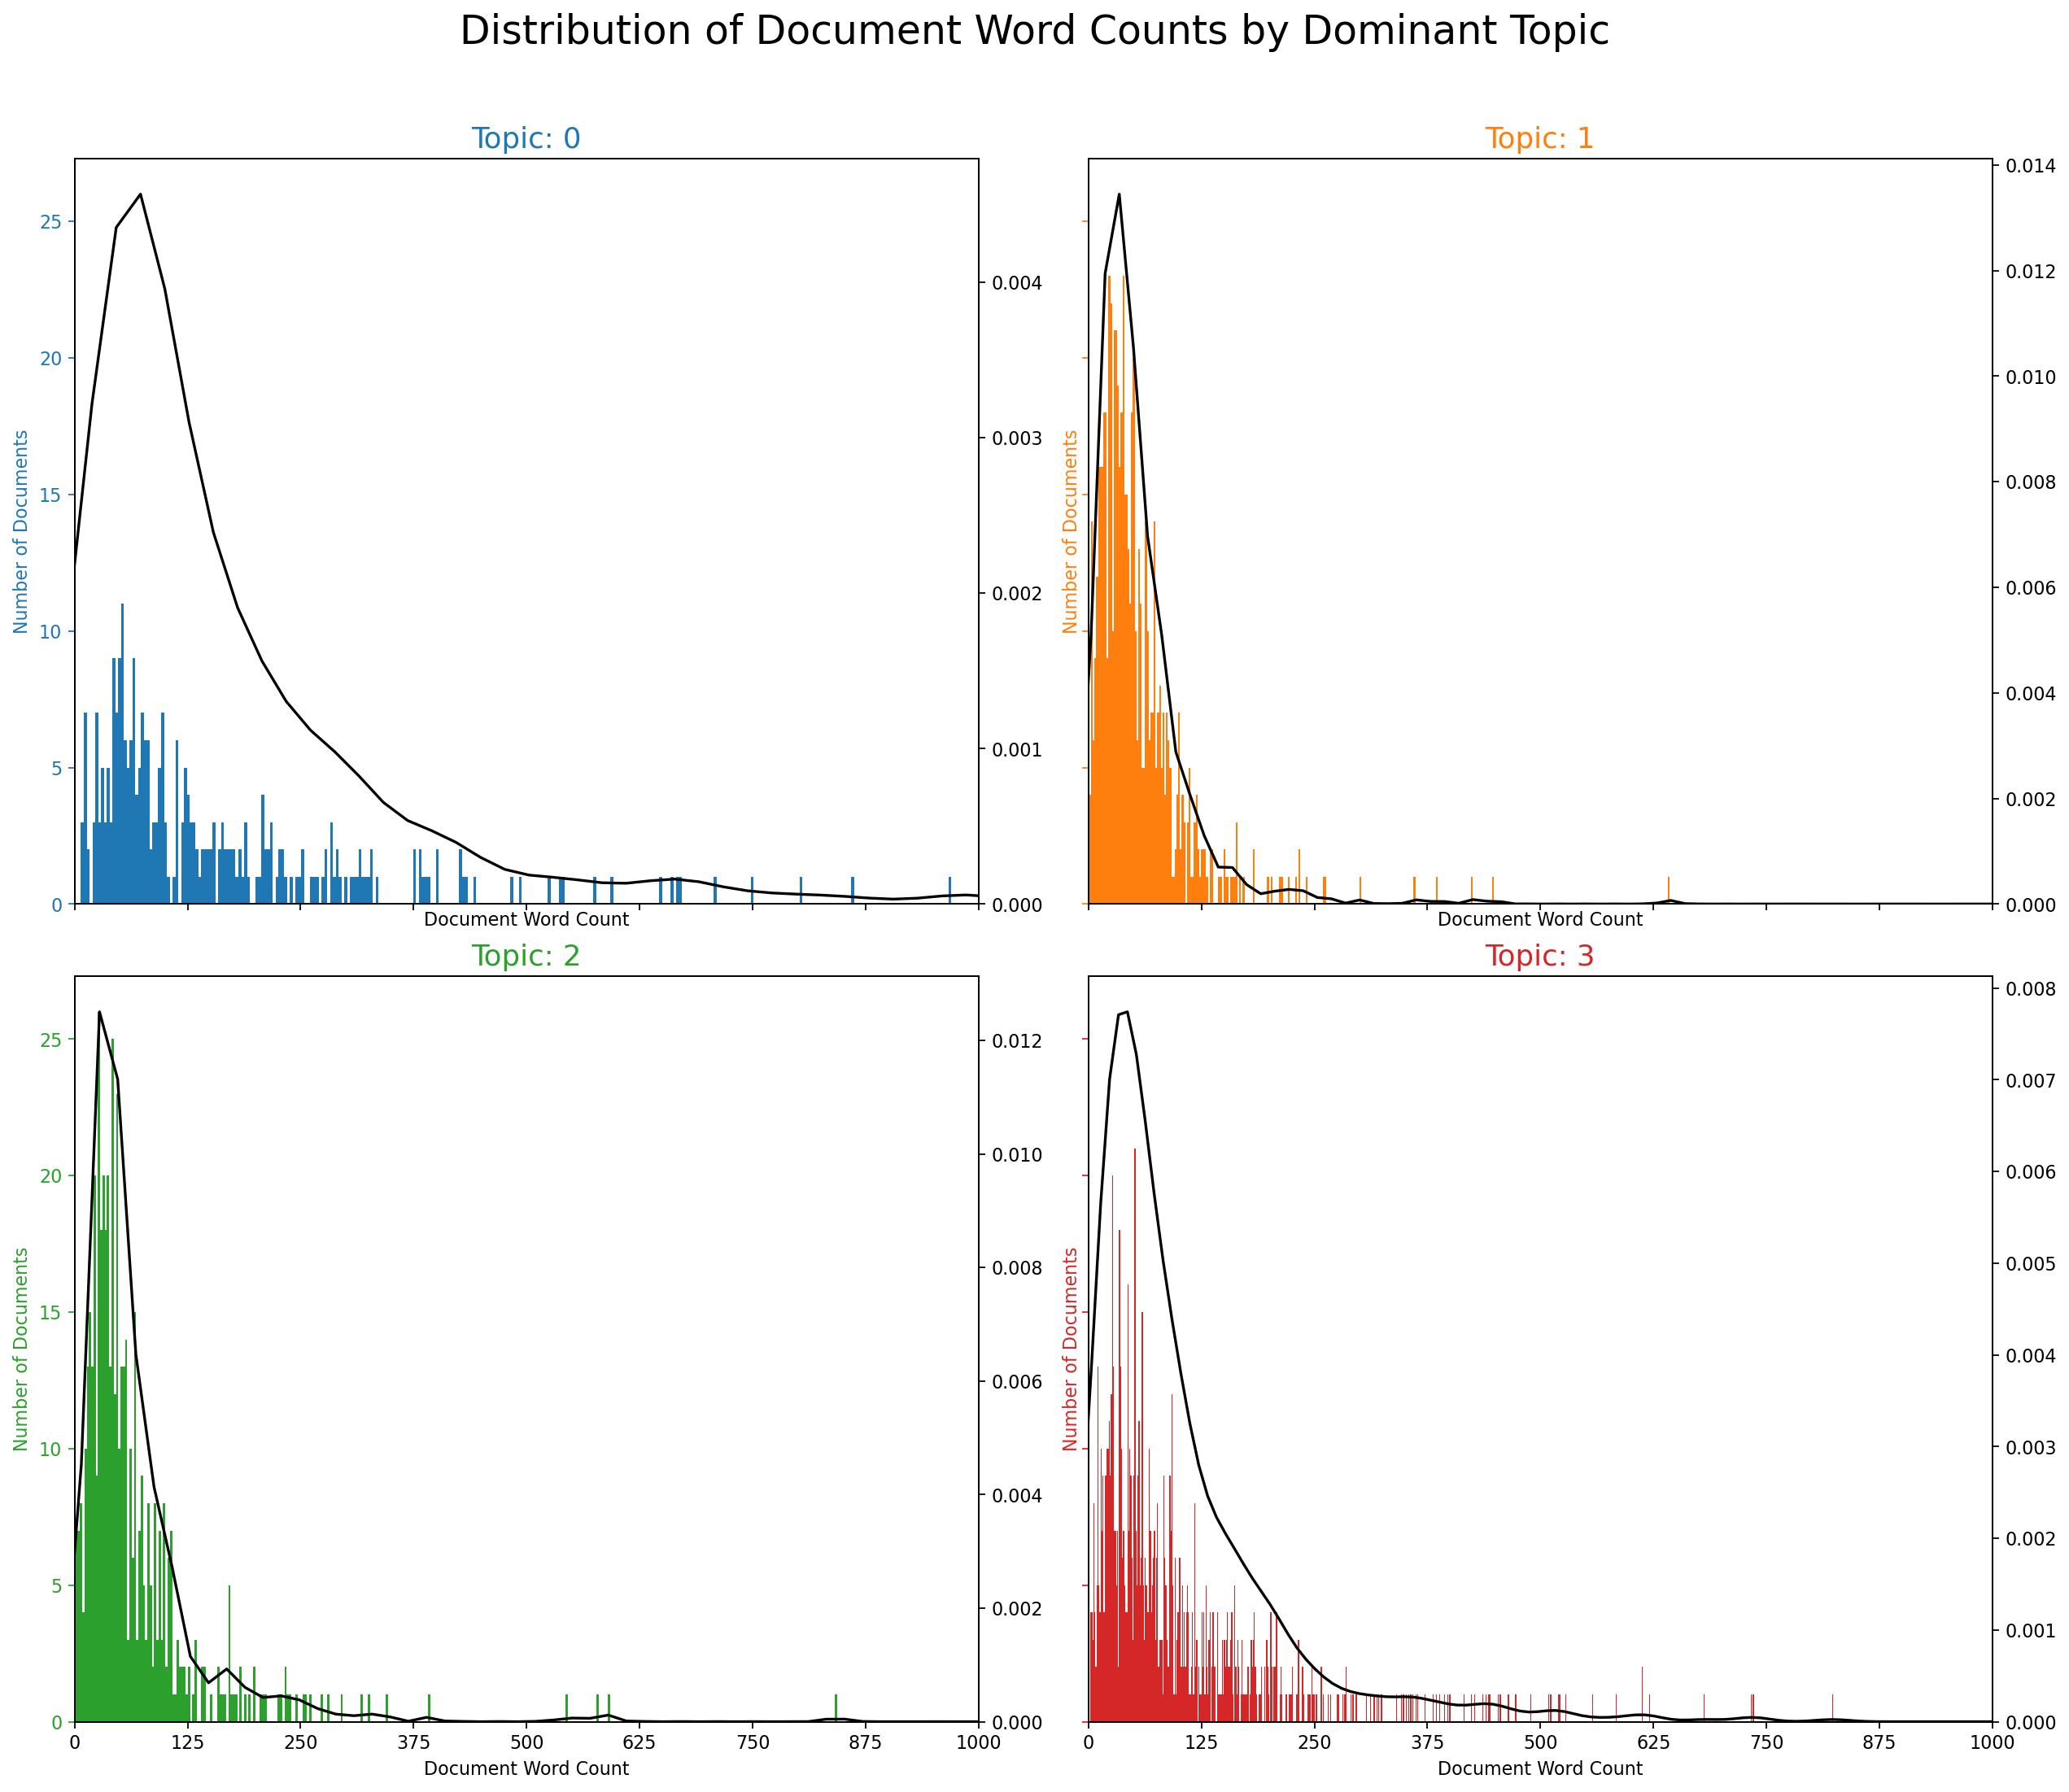

In [12]:
import seaborn as sns
import matplotlib.colors as mcolors
cols = [color for name, color in mcolors.TABLEAU_COLORS.items()]  # more colors: 'mcolors.XKCD_COLORS'

fig, axes = plt.subplots(2,2,figsize=(16,14), dpi=160, sharex=True, sharey=True)

for i, ax in enumerate(axes.flatten()):    
    df_dominant_topic_sub = df_dominant_topic.loc[df_dominant_topic.Dominant_Topic == i, :]
    doc_lens = [len(d) for d in df_dominant_topic_sub.Text]
    ax.hist(doc_lens, bins = 1000, color=cols[i])
    ax.tick_params(axis='y', labelcolor=cols[i], color=cols[i])
    sns.kdeplot(doc_lens, color="black", shade=False, ax=ax.twinx())
    ax.set(xlim=(0, 1000), xlabel='Document Word Count')
    ax.set_ylabel('Number of Documents', color=cols[i])
    ax.set_title('Topic: '+str(i), fontdict=dict(size=16, color=cols[i]))

fig.tight_layout()
fig.subplots_adjust(top=0.90)
plt.xticks(np.linspace(0,1000,9))
fig.suptitle('Distribution of Document Word Counts by Dominant Topic', fontsize=22)
plt.show()

### Word Counts of Topic Keywords
When it comes to the keywords in the topics, the importance (weights) of the keywords matters. Along with that, how frequently the words have appeared in the documents is also interesting to look.

Keep an eye out on the words that occur in multiple topics and the ones whose relative frequency is more than the weight. 

Often such words turn out to be less important and several words need to be added to the stop words list in the beginning and re-running the training process.

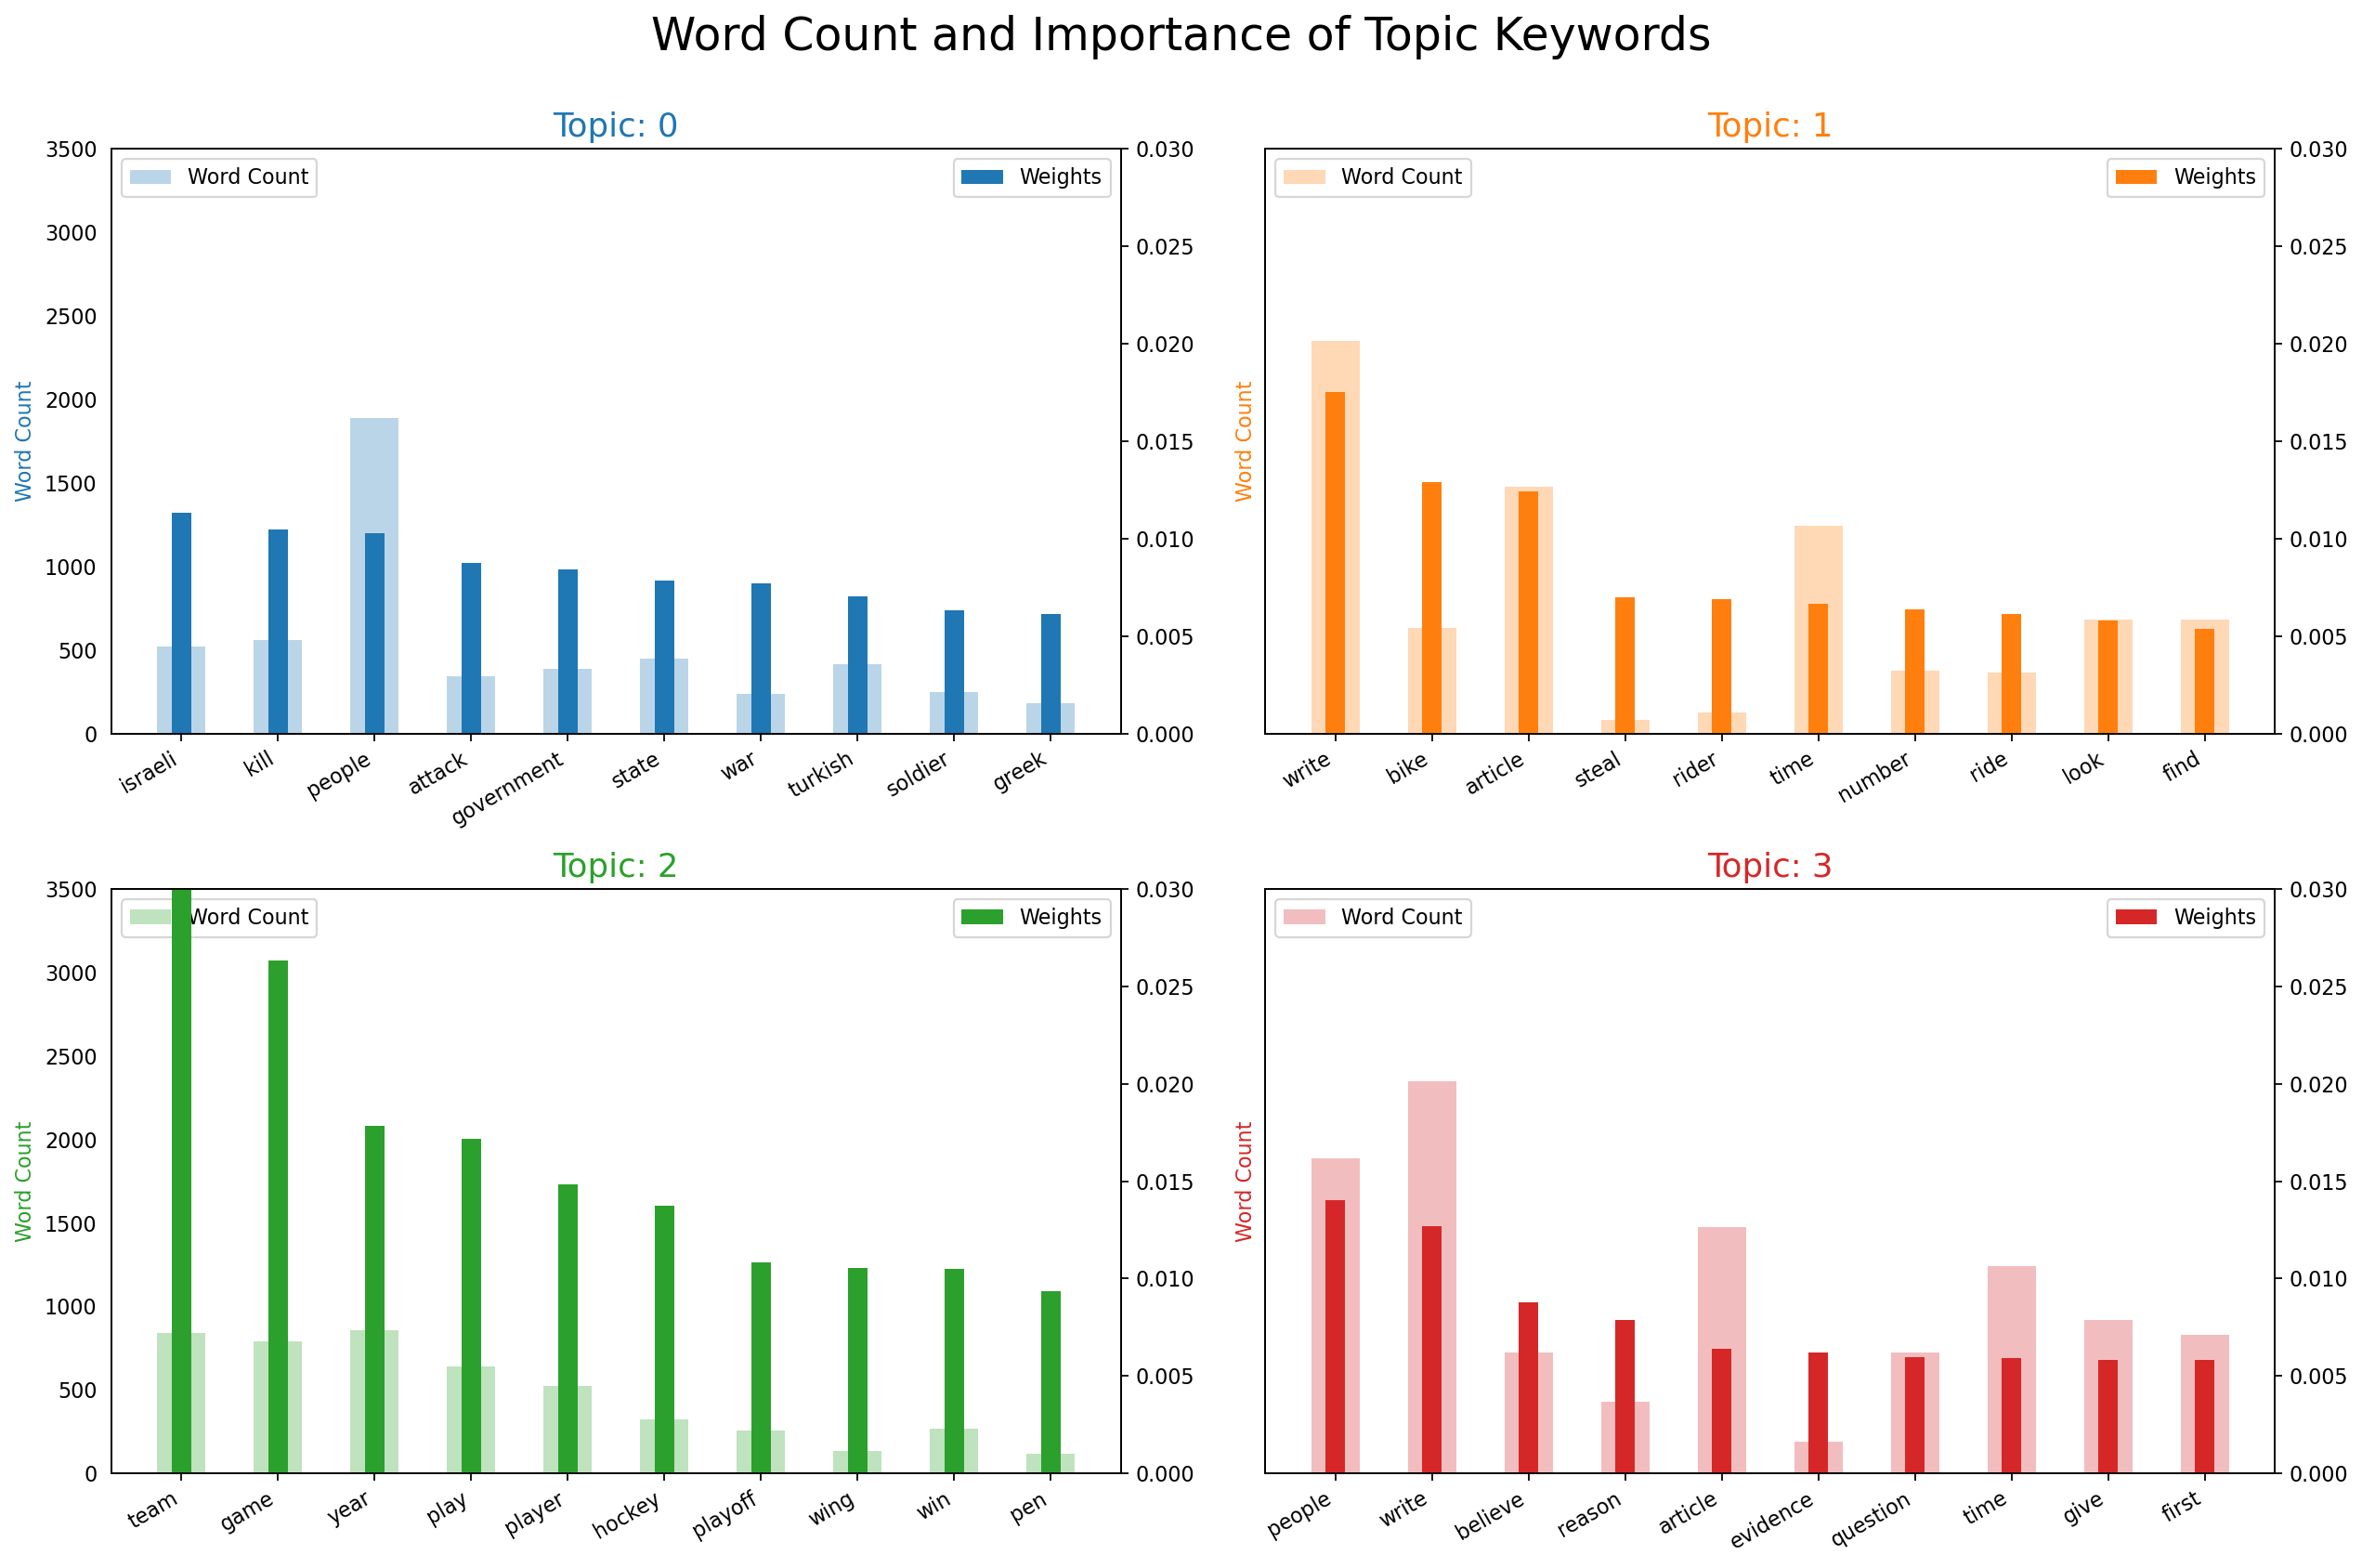

In [13]:
from collections import Counter
topics = lda_model.show_topics(formatted=False)
data_flat = [w for w_list in data_ready for w in w_list]
counter = Counter(data_flat)

out = []
for i, topic in topics:
    for word, weight in topic:
        out.append([word, i , weight, counter[word]])

df = pd.DataFrame(out, columns=['word', 'topic_id', 'importance', 'word_count'])        

# Plot Word Count and Weights of Topic Keywords
fig, axes = plt.subplots(2, 2, figsize=(16,10), sharey=True, dpi=160)
cols = [color for name, color in mcolors.TABLEAU_COLORS.items()]
for i, ax in enumerate(axes.flatten()):
    ax.bar(x='word', height="word_count", data=df.loc[df.topic_id==i, :], color=cols[i], width=0.5, alpha=0.3, label='Word Count')
    ax_twin = ax.twinx()
    ax_twin.bar(x='word', height="importance", data=df.loc[df.topic_id==i, :], color=cols[i], width=0.2, label='Weights')
    ax.set_ylabel('Word Count', color=cols[i])
    ax_twin.set_ylim(0, 0.030); ax.set_ylim(0, 3500)
    ax.set_title('Topic: ' + str(i), color=cols[i], fontsize=16)
    ax.tick_params(axis='y', left=False)
    ax.set_xticklabels(df.loc[df.topic_id==i, 'word'], rotation=30, horizontalalignment= 'right')
    ax.legend(loc='upper left'); ax_twin.legend(loc='upper right')

fig.tight_layout(w_pad=2)    
fig.suptitle('Word Count and Importance of Topic Keywords', fontsize=22, y=1.05)    
plt.show()

### Sentence Chart Colored by Topic
Each word in the document is representative of one of the 4 topics.

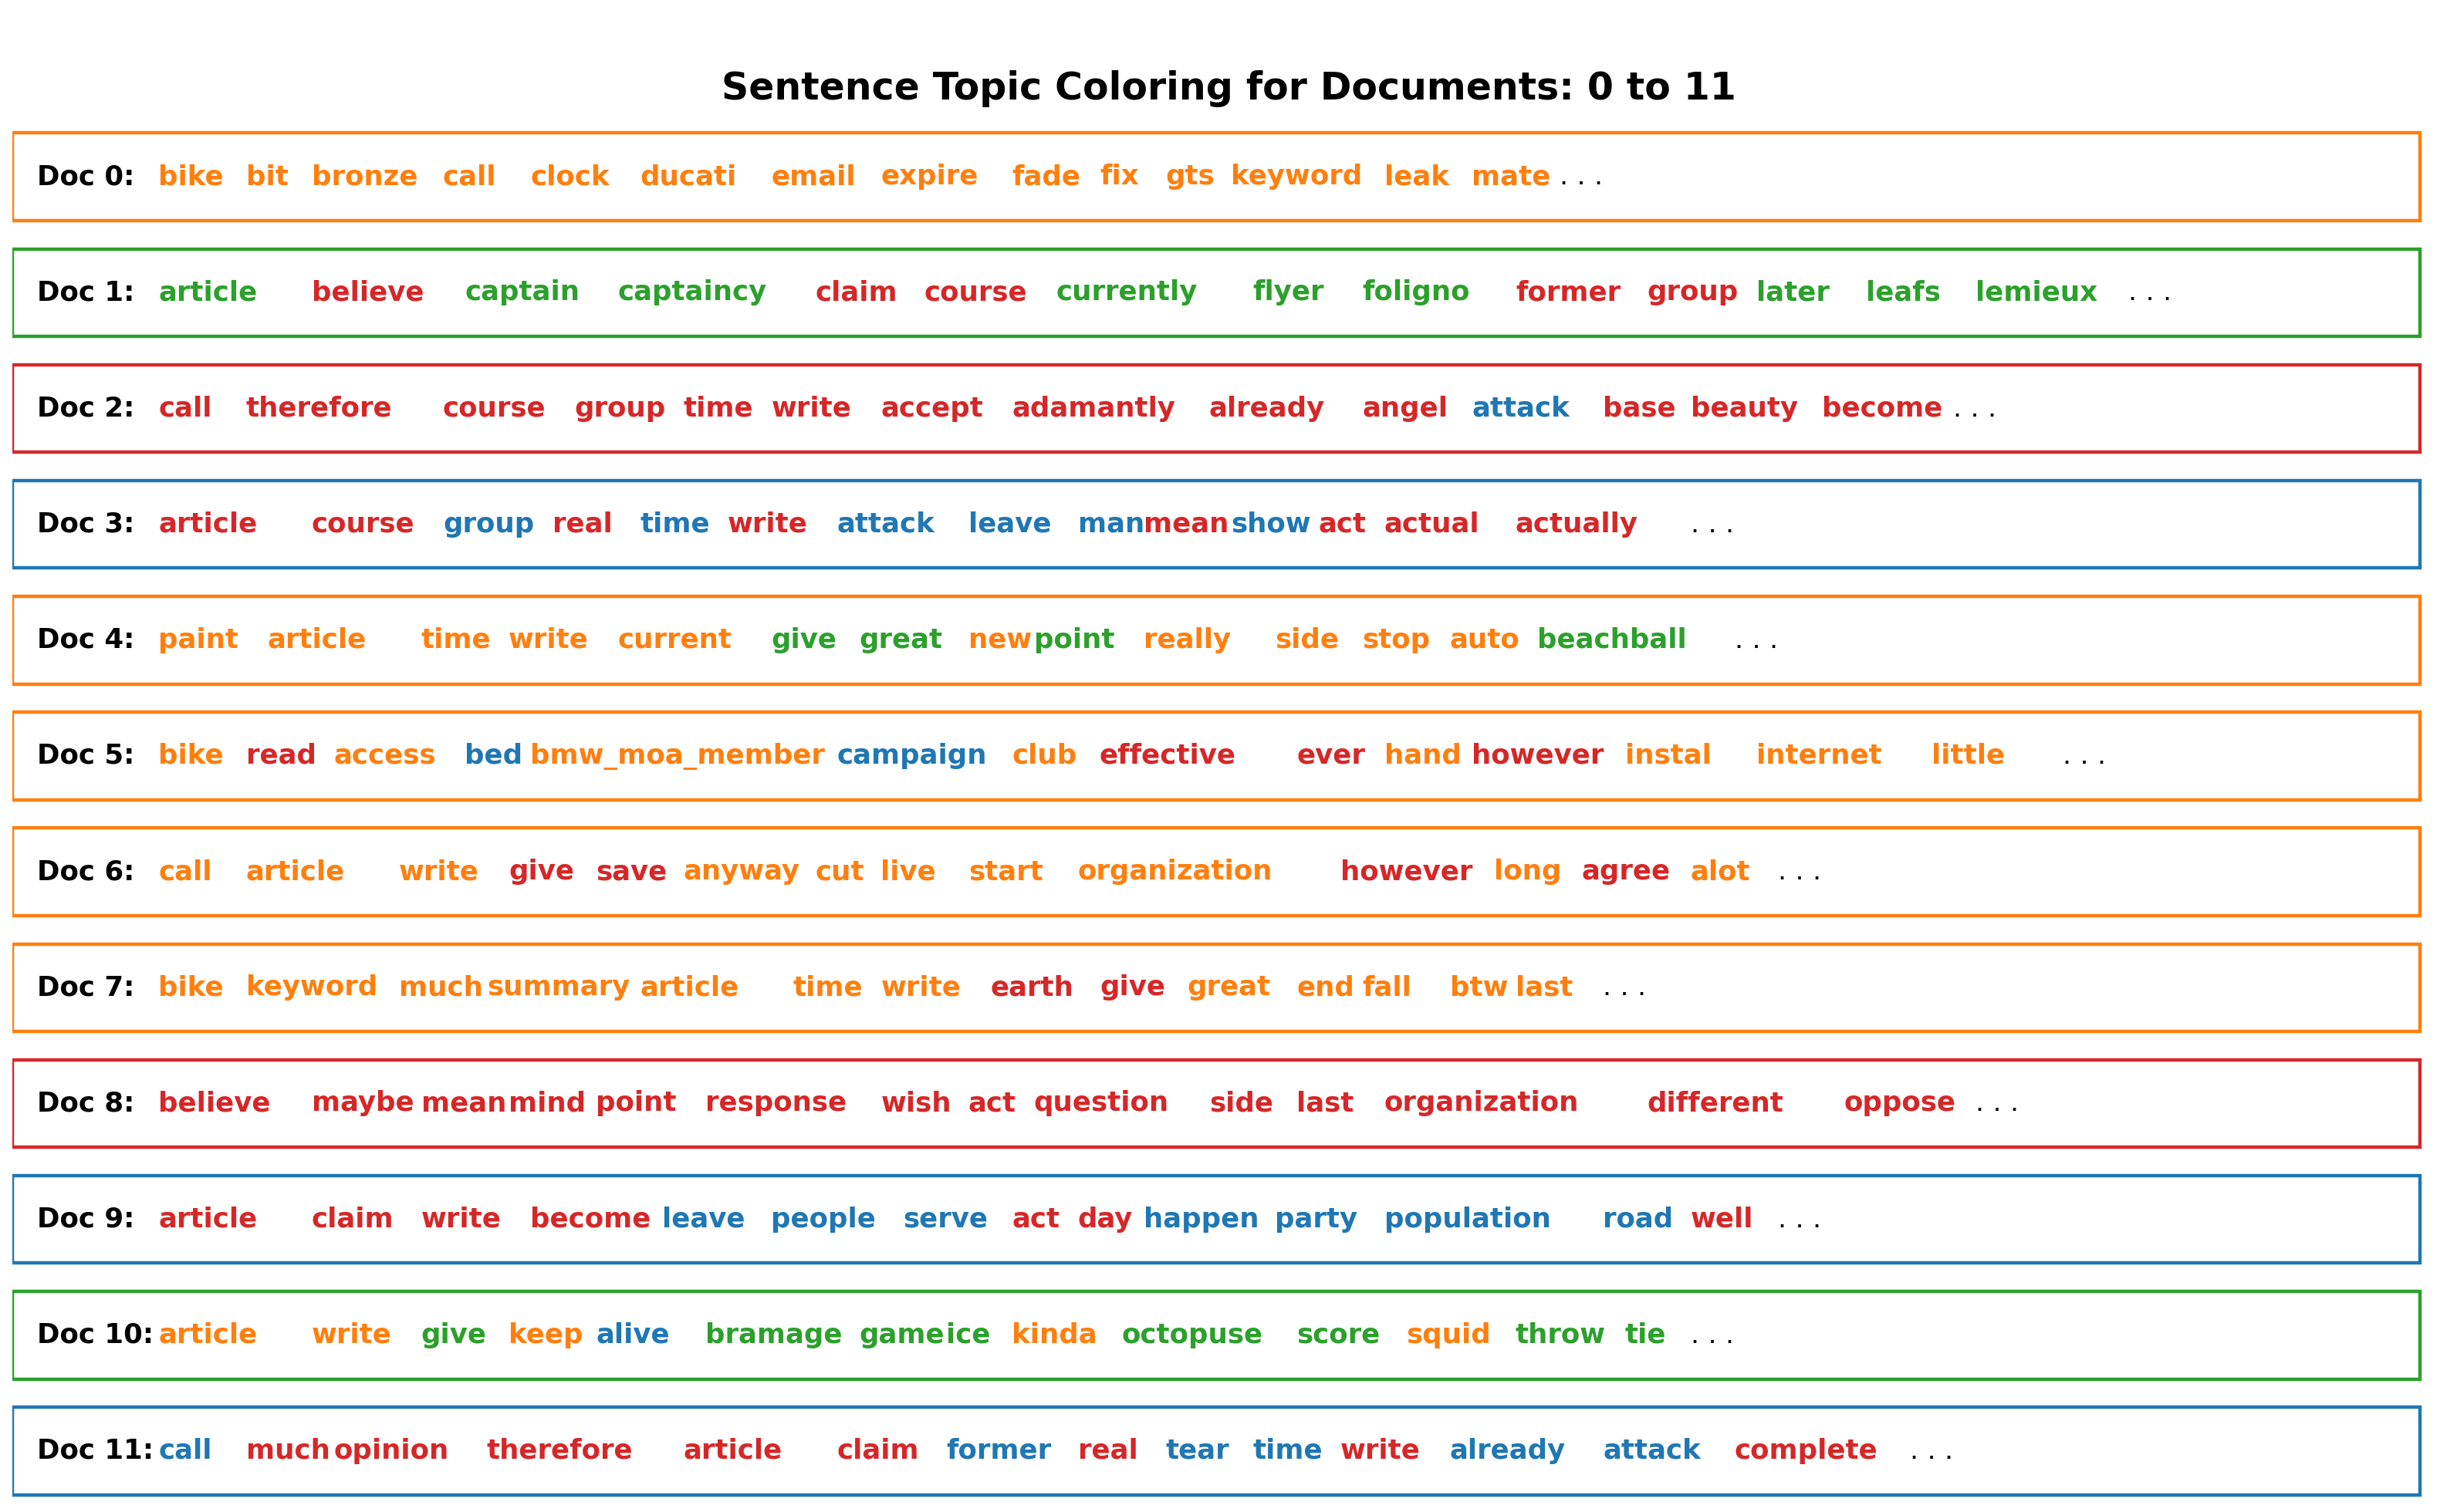

In [14]:
# Sentence Coloring of N Sentences
from matplotlib.patches import Rectangle

def sentences_chart(lda_model=lda_model, corpus=corpus, start = 0, end = 13):
    corp = corpus[start:end]
    mycolors = [color for name, color in mcolors.TABLEAU_COLORS.items()]

    fig, axes = plt.subplots(end-start, 1, figsize=(20, (end-start)*0.95), dpi=160)       
    axes[0].axis('off')
    for i, ax in enumerate(axes):
        if i > 0:
            corp_cur = corp[i-1] 
            topic_percs, wordid_topics, wordid_phivalues = lda_model[corp_cur]
            word_dominanttopic = [(lda_model.id2word[wd], topic[0]) for wd, topic in wordid_topics]    
            ax.text(0.01, 0.5, "Doc " + str(i-1) + ": ", verticalalignment='center',
                    fontsize=16, color='black', transform=ax.transAxes, fontweight=700)

            # Draw Rectange
            topic_percs_sorted = sorted(topic_percs, key=lambda x: (x[1]), reverse=True)
            ax.add_patch(Rectangle((0.0, 0.05), 0.99, 0.90, fill=None, alpha=1, 
                                   color=mycolors[topic_percs_sorted[0][0]], linewidth=2))

            word_pos = 0.06
            for j, (word, topics) in enumerate(word_dominanttopic):
                if j < 14:
                    ax.text(word_pos, 0.5, word,
                            horizontalalignment='left',
                            verticalalignment='center',
                            fontsize=16, color=mycolors[topics],
                            transform=ax.transAxes, fontweight=700)
                    word_pos += .009 * len(word)  # to move the word for the next iter
                    ax.axis('off')
            ax.text(word_pos, 0.5, '. . .',
                    horizontalalignment='left',
                    verticalalignment='center',
                    fontsize=16, color='black',
                    transform=ax.transAxes)       

    plt.subplots_adjust(wspace=0, hspace=0)
    plt.suptitle('Sentence Topic Coloring for Documents: ' + str(start) + ' to ' + str(end-2), fontsize=22, y=0.95, fontweight=700)
    plt.tight_layout()
    plt.show()

sentences_chart() 

# pyLDAVis

### pyLDAVis is the most commonly used and a nice way to visualise the information contained in a topic model.

In [16]:
import pyLDAvis.gensim
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(lda_model, corpus, dictionary=lda_model.id2word)
vis

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
3     -0.138095  0.222083       1        1  44.075600
0     -0.187302 -0.225620       2        1  21.830111
1      0.082997  0.078091       3        1  21.676472
2      0.242401 -0.074554       4        1  12.417815, topic_info=       Term        Freq        Total Category  logprob  loglift
1025   team  961.000000   961.000000  Default  30.0000  30.0000
565    game  737.000000   737.000000  Default  29.0000  29.0000
43     play  481.000000   481.000000  Default  28.0000  28.0000
275    year  909.000000   909.000000  Default  27.0000  27.0000
0      bike  629.000000   629.000000  Default  26.0000  26.0000
...     ...         ...          ...      ...      ...      ...
242    well  167.824905   764.669067   Topic4  -5.1151   0.5695
52    write  199.042862  2388.586914   Topic4  -4.9445  -0.3989
263    last  131.317429   420.772827   Topic4  -5.3604   0.9216
49     time  157.151886  1211.594849   Topic4  -5.1808   0.0436
134    show  121.885551   373.808197   Topic4  -5.4350   0.9654

[221 rows x 6 columns], token_table=      Topic      Freq      Term
term                           
407       1  0.996341    answer
154       2  0.993932      arab
410       1  0.995289  argument
451       2  0.997048  armenian
27        1  0.433634   article
...     ...       ...       ...
52        4  0.083313     write
1423      1  0.995899     wrong
275       2  0.319970      year
275       3  0.130847      year
275       4  0.548677      year

[267 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[4, 1, 2, 3])